In [1]:
import matplotlib.pyplot as plt
import numpy as np

from braidz_analysis import braidz, plotting, processing

2024-12-17 12:26:14,177 [INFO] 
Limited Linear Model Support Detected! 
---> PYCHEBFUN is not installed. 
---> Install pychebfun to use chebfun derivatives (https://github.com/pychebfun/pychebfun/) 
You can still use other methods 



In [2]:
root_folder = "/home/buchsbaum/mnt/nfc3008/md0/Experiments"
exp_list = [
    "20230116_124945.braidz",
]

combined_data = braidz.read_multiple_braidz(
    exp_list, root_folder=root_folder, parser="pyarrow"
)

2024-12-17 12:35:44,720 [INFO] Processing 1 files


Processing file 1/1: /home/buchsbaum/mnt/nfc3008/md0/Experiments/20230116_124945.braidz


2024-12-17 12:35:45,007 [INFO] Reading /home/buchsbaum/mnt/nfc3008/md0/Experiments/20230116_124945.braidz using pyarrow


In [4]:
data = processing.get_all_saccades(
    combined_data["df"],
    combined_data["opto"],
    post_frames=50,
    use_opto_or_stim_only=True,
)

  0%|          | 0/265 [00:00<?, ?it/s]

100%|██████████| 265/265 [06:39<00:00,  1.51s/it]  


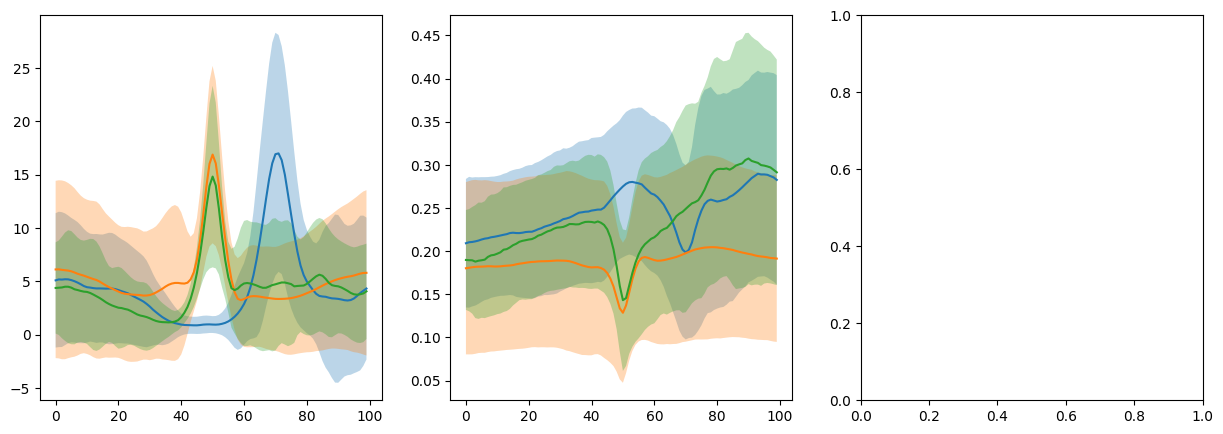

In [7]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 5))

for saccade_type in np.unique(data.saccade_type):
    plotting.plot_mean_and_std(
        np.abs(data.angular_velocity[data.saccade_type == saccade_type]),
        ax=axs[0],
        label=saccade_type,
    )

    plotting.plot_mean_and_std(
        data.linear_velocity[data.saccade_type == saccade_type],
        ax=axs[1],
        label=saccade_type,
    )

plt.show()

# Understanding the Data Structure

The `combined_data` dictionary contains structured data from braidz files with several key components:

## Key Components
- `df`: Contains the main `kalman_estimates` data (always present)
- `stim`: Contains stimulus-related data (if present)
- `opto`: Contains optogenetics data (if present)

Example of checking available keys:
```
print(f"Available data keys: {list(combined_data.keys())}")
```

## Data Structure
The main DataFrame (`combined_data['df']`) contains various measurements and tracking data. You can examine its structure:

```
# View all columns in the main DataFrame
columns = combined_data['df'].columns
print("Available columns:", columns.tolist())
```

## Working with Groups

The data is organized hierarchically using two main identifiers:
- `obj_id`: Unique identifier for each tracked object (can be the same across different experiments)
- `exp_num`: Experiment number for different recording sessions

### Grouping Patterns

1. Group by object:
```
object_groups = combined_data['df'].groupby('obj_id')
```

2. Group by experiment:
```
experiment_groups = combined_data['df'].groupby('exp_num')
```

3. Group by both (most common use case):
```
# This creates groups for each unique object within each experiment
obj_exp_groups = combined_data['df'].groupby(['obj_id', 'exp_num'])
```